In [16]:
include("FFTWrapper.jl")

using Plots
plotly()

Plots.PlotlyBackend()

$$
\hat{f}=r^2[12 (|k| \hat{h})*(|k| \hat{h})-8 (k^2 \hat{h})*\hat{h}-4(k \hat{h})*(k \hat{h})]
$$

In [18]:
f̂(ĥ,ω;r=1.5) = r^2*(12conv(abs.(ω) .* ĥ)-8conv(ĥ,ω .^ 2 .* ĥ)-4conv(ω .* ĥ))

f̂ (generic function with 1 method)

In [24]:
function solve(ĥ⁰::Vector,N;L=2π,Δt=0.01,r=1.5,M=1000)
    ω = 2π*rfftfreq(N,N/L)
    λ = @. 4r^3*abs(ω)^3-r^4*ω^4
    f̂⁰ = f̂(ĥ⁰,ω;r=r)
    update(ĥⁿ,f̂ⁿ,f̂ⁿ⁻¹) = @. ((1/Δt+λ/2)*ĥⁿ-r^2*ω^2*(3*f̂ⁿ/2-f̂ⁿ⁻¹/2))/(1/Δt-λ/2)
    ĥ = zeros(ComplexF64,length(ĥ⁰),M)
    t = 0:Δt:M*Δt
    ĥ[:,1] = update(ĥ⁰,f̂⁰,f̂⁰)
    f̂ⁱ⁻¹ = f̂⁰
    for i in 1:M-1
        f̂ⁱ = f̂(ĥ[:,i],ω;r=r)
        ĥ[:,i+1] = update(ĥ[:,i],f̂ⁱ,f̂ⁱ⁻¹)
        f̂ⁱ⁻¹ = f̂ⁱ
    end
    return t,[ĥ⁰ ĥ]
end

solve (generic function with 2 methods)

In [113]:
N = 101
M = 40
L = 2π
Δt = 0.01
rs = [1.5;3.8;5]
h₀(x) = 0.01cos(x)
ĥ⁰ = rfftemplate(N)
ĥ⁰[1+1] = 0.01

hs = Dict()
for r in rs
    t,ĥ = solve(ĥ⁰,N;L=L,r=r,Δt=Δt,M=M)
    hs[r] = zeros(Float64,N,M+1)
    for t in 1:M+1
       hs[r][:,t] = irfft(ĥ[:,t],N) 
    end
end

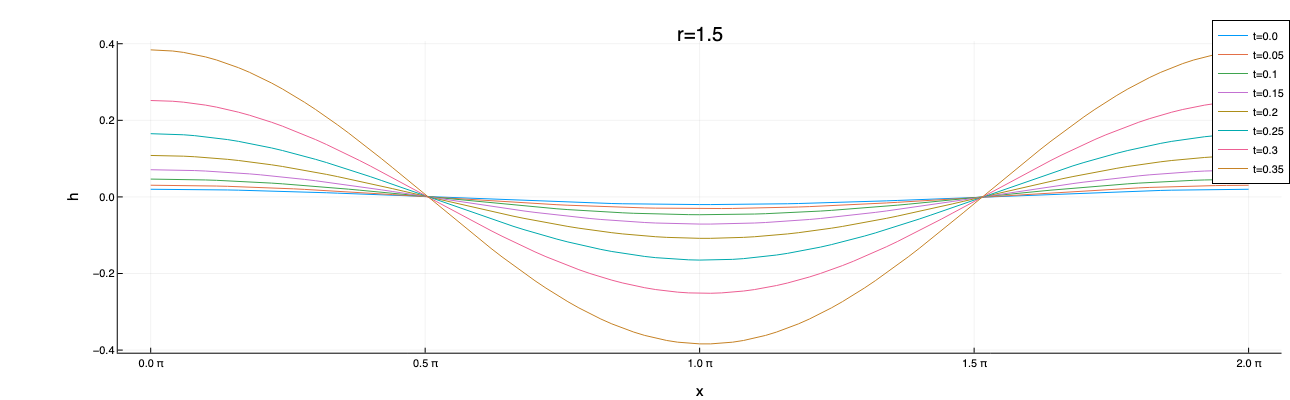

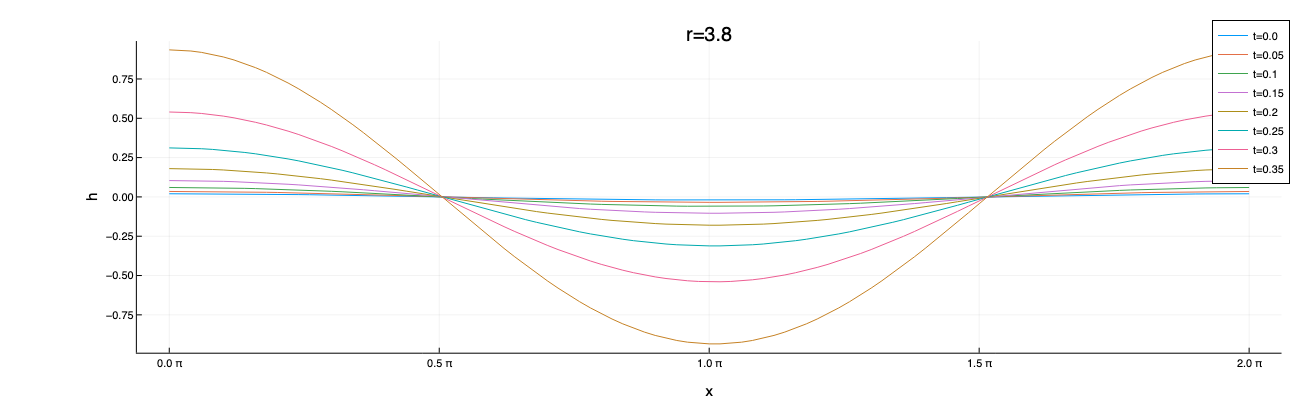

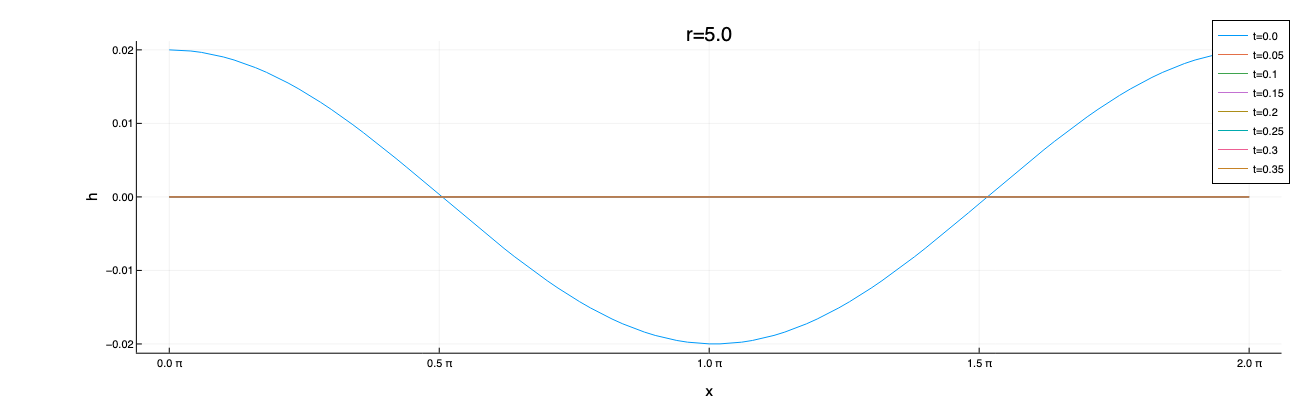

In [135]:
x = range(0,2π,length=N)
for r in rs
    p = plot(size = (600, 400), title="r=$r")
    for i in range(1,stop=M,step=5)
        plot!(p, x, hs[r][:,i] ,label="t=$(t[i])")
    end
    xlabel!(p,"x")
    ylabel!(p,"h")
    idxs = Vector(0:0.5:2)
    xticks!(p,(π * idxs,string.(idxs).* " π"))
    display(p)
end

In [129]:
for r in rs
    p = surface(hs[r],size=(600,500))
    xlabel!(p,"t")
    tidxs = Vector(range(1,M+1,step=10))
    xticks!(p,(tidxs,string.(t[tidxs])))
    idxs = Vector(range(0,N-1,step=25))
    yticks!(p,(idxs,string.(2*idxs/(N-1)).* " π"))
    ylabel!(p,"x")
    zlabel!(p,"h")
    title!(p,"r=$r")
    display(p)
end